In [ ]:
import torch
import pandas as pd
import os 
import sys
import glob
import pickle 
from datetime import datetime

current_path = notebook_dir = os.getcwd()
working_dir = os.path.abspath(os.path.join(current_path, '..'))
if working_dir not in sys.path:
    sys.path.insert(0, working_dir)
    
from constants.paths import FILE_NAME,FOLDER_PATH
from bokeh.plotting import figure, show,output_notebook,save,output_file
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, Legend, HoverTool, TapTool, CustomJS
import pandas as pd
from bokeh.palettes import Set3


apps =  pickle.load(open(f"{FOLDER_PATH}NetMob_DL_video_Lyon_APP.pkl","rb"))
netmob_T = torch.load(f"{FOLDER_PATH}NetMob_DL_video_Lyon.pt")[:,:,110:-40,85:-55]
netmob_T = netmob_T.permute(1,0,2,3)
start,end = datetime(2019,3,16,0,0),datetime(2019,6,1,0,0)
timeslots = pd.date_range(start,end,freq = '15min')
timeslots = timeslots[:-1]
df_plot = pd.DataFrame(netmob_T.sum(axis = [2,3]),index = timeslots,columns = apps)

In [70]:
def find_positions(applications, file_list):
    positions = []
    for app in applications:
        for idx, file_path in enumerate(file_list):
            if app == file_path:
                positions.append(idx)
    return positions

def plotting_pattern_netmob(selected_apps,positions,name_save,weeknames,months,timeslots,horaires):
    figures = []
    for weekday in range(len(weeknames)):
        row_figs = []  # Une ligne de figures pour chaque jour de la semaine
        for app_ind in range(len(selected_apps)):
            # Préparation des données pour chaque application et jour de la semaine
            data_dict = {}
            idx1 = 0
            k = 0
            
            # Tackle a specific weekday :
            while idx1 < len(timeslots)-1-7*96:
                #idx1,idx2 = 96*(16+weekday+k*7),96*(16+weekday+k*7+1)
                idx1,idx2 = 96*(weekday+k*7),96*(weekday+k*7+1)
                day_name = weeknames[timeslots[idx1].weekday()]
                month_name = months[timeslots[idx1].month-1]
                day_num = timeslots[idx1].day    
                
                pos = positions[app_ind]
                globals()[f'{day_name}_{day_num}_{month_name}'] = df_plot.iloc[idx1:idx2,pos]
                data_dict[f'{day_name}_{day_num}_{month_name}'] = globals()[f'{day_name}_{day_num}_{month_name}'].values.reshape(-1)
                k = k+1


            df_to_plot = pd.DataFrame(data_dict, index=horaires)

            # Création de la figure Bokeh
            p_fig = figure(x_range=horaires, title=f'{selected_apps[app_ind]} - {day_name}',width=900, height=900)
            p_fig.xaxis.major_label_orientation = 1.2  # Pour faire pivoter les labels des x

            # Ajouter les lignes au graphique avec légende
            legend_items = []

            for j in range(k):
                #idx1,idx2 = 96*(16+weekday+j*7),96*(16+weekday+j*7+1)
                idx1,idx2 = 96*(weekday+j*7),96*(weekday+j*7+1)
                day_name = weeknames[timeslots[idx1].weekday()]
                month_name = months[timeslots[idx1].month-1]
                day_num = timeslots[idx1].day   
                line = p_fig.line(horaires, df_to_plot[f'{day_name}_{day_num}_{month_name}'], 
                                  line_width=2, 
                                  legend_label=f'{day_name}_{day_num}_{month_name}',
                                  color = colors[j]
                                 )
                legend_items.append((f'{day_name}_{day_num}_{month_name}', [line]))


            # Ajout de la légende
            p_fig.legend.title = "Séries"
            p_fig.legend.location = "top_left"
            p_fig.legend.click_policy="hide"
            p_fig.add_tools(HoverTool())  # Ajouter HoverTool pour interactivité

            # Définir la limite Y max
            y_max = df_to_plot.max().max()
            p_fig.y_range.start = 0
            p_fig.y_range.end = y_max

            # Ajouter la figure à la ligne des figures
            row_figs.append(p_fig)

        # Ajouter la ligne complète à la grille des figures
        figures.append(row_figs)


    # Créer la grille de subplots avec des figures agrandies
    grid = gridplot(figures)   


    # Afficher la grille
    #output_notebook()
    #show(grid)
    #output_file(filename=f"NetMob_Visualisation/All Apps/NetMob_Pattern_{name_save}.html")
    output_file(filename=f"NetMob_Visualisation/Group of Apps/NetMob_Pattern_{name_save}.html")
    save(grid)

In [71]:
# Paramètres
p = 100
weeknames = ['lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche']
months = ['Janvier','Fevrier','Mars','Avril','Mai','Juin','Juillet','Aout','Septembre','Octobre','Novembre','Decembre']
colors = Set3[12]
# Création des horaires pour l'axe des x
horaires = []
for heure in range(24):
    for minute in [0, 15, 30, 45]:
        horaires.append(f'{heure:02d}:{minute:02d}')

        
trafic_apps = ['Uber', 'Google_Maps','Waze']
music_apps = ['Spotify','Deezer','Apple_Music','Apple_iTunes','SoundCloud']
direct_messenger_apps = ['Telegram','Apple_iMessage','Facebook_Messenger','Snapchat','WhatsApp']
social_networks_apps = ['Twitter', 'Pinterest','Facebook','Instagram']        
        
        

'''Generate plot for every single apps: '''
if False: 
    modulo = 5
    for subset_apps in range(len(apps)//modulo):
        if subset_apps == len(apps)//modulo-1:
            selected_apps = apps[subset_apps*5:]
        else: 
            selected_apps = apps[subset_apps:subset_apps+5]
        # Stocker les figures Bokeh dans une grille
        
        # Boucle sur les jours de la semaine (7 jours)

        name_save = ' '.join(selected_apps)


''' Generate plot for specific group of apps: '''
if True: 
    for selected_apps,name_save in zip([trafic_apps,music_apps,direct_messenger_apps,social_networks_apps],['trafic_apps','music_apps','direct_messenger_apps','social_networks_apps']):
        positions = find_positions(selected_apps, apps)
        plotting_pattern_netmob(selected_apps,positions,name_save,weeknames,months,timeslots,horaires)

## Visu de Volume Subway comparé avec NetMob : 

In [82]:
from constants.paths import FOLDER_PATH,FILE_NAME
from constants.config import get_args
from utils.utilities_DL import match_period_coverage_with_netmob,get_small_ds,get_DataSet_and_invalid_dates

model_name = 'STGCN'
args = get_args(model_name)

dataset_names = ['subway_in','netmob']
coverage = match_period_coverage_with_netmob(FILE_NAME,dataset_names)
(coverage,args) = get_small_ds(False,coverage,args)  #small_ds = False

dataset,invalid_dates = get_DataSet_and_invalid_dates(args.W,args.D,args.H,args.step_ahead,
                                                    single_station = False,coverage_period = coverage)

Time-step per hour: 4.0
coverage period: 2019-03-16 00:00:00 - 2019-05-31 23:45:00


In [129]:
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show,output_notebook

S_volume = dataset.df.sum(axis=1).iloc[96*16:96*(16+7)]
S_volume = S_volume/S_volume.max() 
S_volume.name = 'Subway Volume'

S_deezer = df_plot['Deezer'].iloc[96*16:96*(16+7)]
S_deezer = S_deezer/S_deezer.max()
S_deezer.name = 'Deezer Consumption' 

S_spotify = df_plot['Spotify'].iloc[96*16:96*(16+7)]
S_spotify = S_spotify/S_spotify.max()
S_spotify.name = 'Spotify Consumption' 

S_uber = df_plot['Uber'].iloc[96*16:96*(16+7)]
S_uber = S_uber/S_uber.max()
S_uber.name = 'Uber Consumption' 

S_google_map = df_plot['Google_Maps'].iloc[96*16:96*(16+7)]
S_google_map = S_google_map/S_google_map.max()
S_google_map.name = 'Google Maps Consumption'

S_whatsapp = df_plot['WhatsApp'].iloc[96*16:96*(16+7)]
S_whatsapp = S_whatsapp/S_whatsapp.max()
S_whatsapp.name = 'WhatsApp Consumption'

df_app = pd.DataFrame({'Subway Volume':S_volume, 
                       'Deezer Consumption':S_deezer,
                       'Spotify Consumption': S_spotify,
                       'Uber Consumption': S_uber,
                       'Google Maps Consumption': S_google_map,
                       'WhatsApp Consumption': S_whatsapp,
                      })

#Bokeh plot 
df_app['date'] = df_app.index 

p = figure(x_axis_type="datetime", 
           title=f'Comparison between traffic volume and Deezer App consumption. \nVolume and Apps consumption have beend summed through every single \nspatial unit of Lyon, and then MinMaxNormalized',
           width=600, height=600)
p.xaxis.major_label_orientation = 1.2  # Pour faire pivoter les labels des x
p.line(x=df_app['date'], line_width = 2.5, y=df_app['Subway Volume'],legend_label = 'Subway Volume', color='blue')
p.line(x=df_app['date'], line_width = 2.5, y=df_app['Deezer Consumption'],legend_label ='Deezer Consumption' ,color = 'orange')
p.line(x=df_app['date'], line_width = 2.5, y=df_app['Spotify Consumption'],legend_label ='Spotify Consumption' ,color = 'red')
p.line(x=df_app['date'], line_width = 2.5, y=df_app['Uber Consumption'],legend_label = 'Uber Consumption', color='green')
p.line(x=df_app['date'], line_width = 2.5, y=df_app['Google Maps Consumption'],legend_label ='Google Maps Consumption' ,color = 'purple')
p.line(x=df_app['date'], line_width = 2.5, y=df_app['WhatsApp Consumption'],legend_label = 'WhatsApp Consumption', color='pink')

p.legend.location = "top_right"
p.legend.click_policy="hide"
p.add_tools(HoverTool())  # Ajouter HoverTool pour interactivité
output_notebook()
show(p)


Loading BokehJS ...

<Axes: >

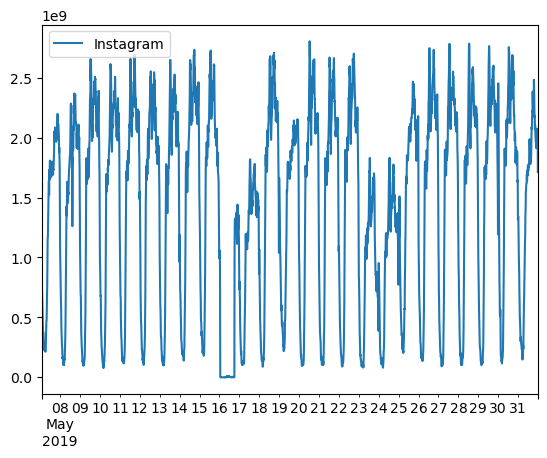

In [43]:
pos = find_positions(['Whatsapp','Instagram'], apps)
df_plot.iloc[5000:,pos].plot()